This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Handling DX Radar Data (German Weather Service)

This tutorial helps you to read and plot the raw polar radar data provided by German Weather Service (DWD).

In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

/home/runner/micromamba/envs/wradlib-tests/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Reading DX-Data

The German weather service provides polar radar data in the so called ``DX`` format. 
These have to be unpacked and transfered into an array of 360 (azimuthal resolution of 1 degree) by 128 (range resolution of 1 km).

The naming convention for DX data is: 
<pre>raa00-dx_&lt;location-id&gt;-&lt;YYMMDDHHMM&gt;-&lt;location-abreviation&gt;---bin</pre> or <pre>raa00-dx_&lt;location-id&gt;-&lt;YYYYMMDDHHMM&gt;-&lt;location-abreviation&gt;---bin</pre> 
For example: ``raa00-dx_10908-200608281420-fbg---bin`` raw data from radar station Feldberg (fbg, 10908) from 2006-08-28 14:20:00.

Each DX file also contains additional information like the elevation angle for each beam. Note, however, that the format is not "self-describing".

### Raw data for one time step

Suppose we want to read a radar-scan for a defined time step. You need to make sure that the data file is given with the correct path to the file. The read_dx function returns two variables: the reflectivity array, and a dictionary of metadata attributes.

In [2]:
filename = wrl.util.get_wradlib_data_file("dx/raa00-dx_10908-200608281420-fbg---bin.gz")
one_scan, attributes = wrl.io.read_dx(filename)
print(one_scan.shape)
print(attributes.keys())
print(attributes["radarid"])

(360, 128)
dict_keys(['producttype', 'datetime', 'radarid', 'bytes', 'version', 'cluttermap', 'dopplerfilter', 'statfilter', 'elevprofile', 'message', 'elev', 'azim', 'clutter'])
10908


### Raw data for multiple time steps

To read multiple scans into one array, you should create an empty array with the shape of the desired dimensions. 
In this example, the dataset contains 2 timesteps of 360 by 128 values. Note that we simply catch the metadata dictionary
in a dummy variable:

In [3]:
import numpy as np

two_scans = np.empty((2, 360, 128))
metadata = [[], []]
filename = wrl.util.get_wradlib_data_file("dx/raa00-dx_10908-0806021740-fbg---bin.gz")
two_scans[0], metadata[0] = wrl.io.read_dx(filename)
filename = wrl.util.get_wradlib_data_file("dx/raa00-dx_10908-0806021745-fbg---bin.gz")
two_scans[1], metadata[1] = wrl.io.read_dx(filename)
print(two_scans.shape)

(2, 360, 128)


## Visualizing dBZ values

Now we want to create a quick diagnostic PPI plot of reflectivity in a polar coordiate system:

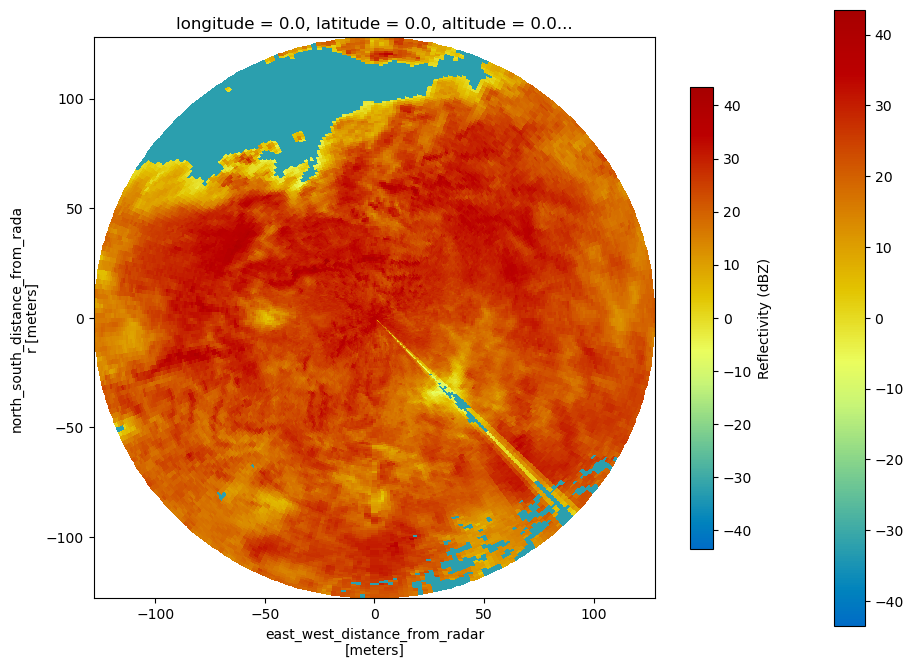

In [4]:
plt.figure(figsize=(10, 8))
da = wrl.georef.create_xarray_dataarray(one_scan).wrl.georef.georeference()
pm = da.wrl.vis.plot()
# add a colorbar with label
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label("Reflectivity (dBZ)")

This is a stratiform event. Apparently, the radar system has already masked the foothills of the Alps as clutter. 
The spike in the south-western sector is caused by a broadcasting tower nearby the radar antenna.

Another case shows a convective situation:

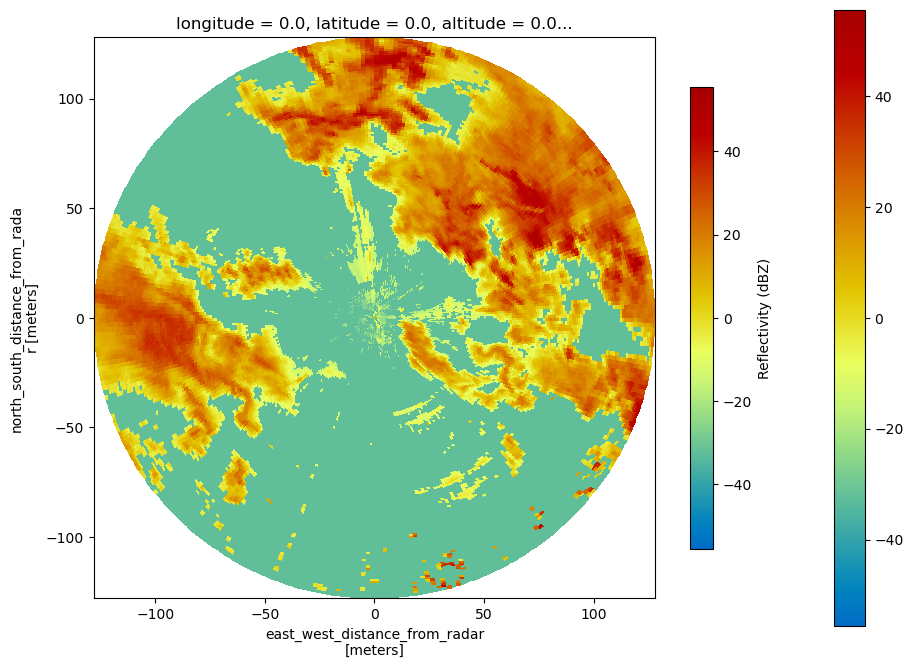

In [5]:
plt.figure(figsize=(10, 8))
da = wrl.georef.create_xarray_dataarray(two_scans[0]).wrl.georef.georeference()
pm = da.wrl.vis.plot()
cbar = plt.colorbar(pm, shrink=0.75)
cbar.set_label("Reflectivity (dBZ)")

You can also modify or decorate the image further, e.g. add a cross-hair, a title, use a different colormap, or zoom in:

(-128.0, 128.0)

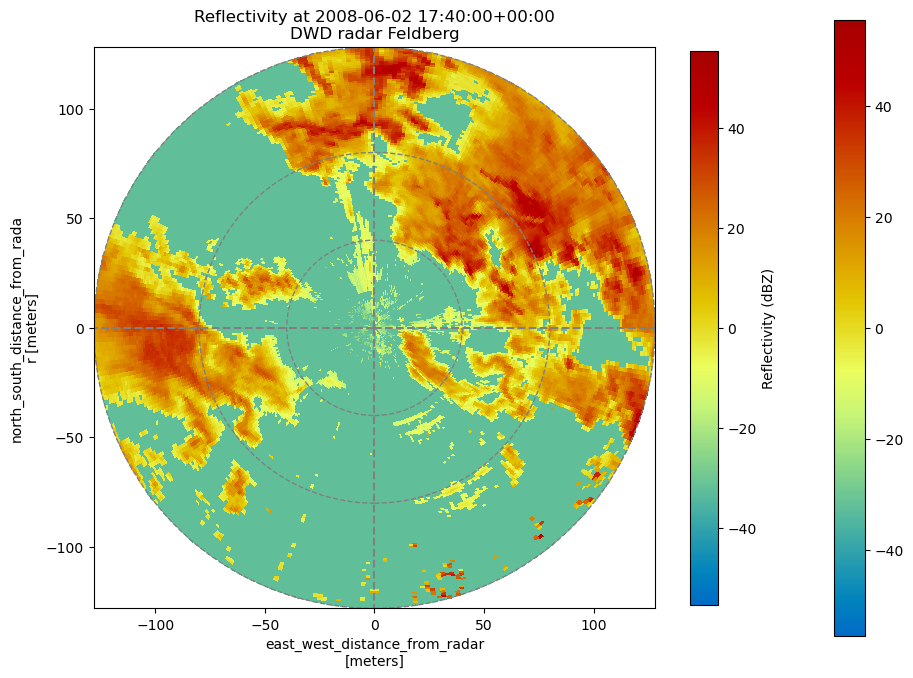

In [6]:
plt.figure(figsize=(10, 8))
# Plot PPI,
pm = da.wrl.vis.plot()
# add crosshair,
ax = wrl.vis.plot_ppi_crosshair((0, 0, 0), ranges=[40, 80, 128])
# add colorbar,
cbar = plt.colorbar(pm, shrink=0.9)
cbar.set_label("Reflectivity (dBZ)")
# add title,
plt.title("Reflectivity at {0}\nDWD radar Feldberg".format(metadata[0]["datetime"]))
# and zoom in.
plt.xlim((-128, 128))
plt.ylim((-128, 128))

In addition, you might want to tweak the colorscale to allow for better comparison of different images:

(-128.0, 128.0)

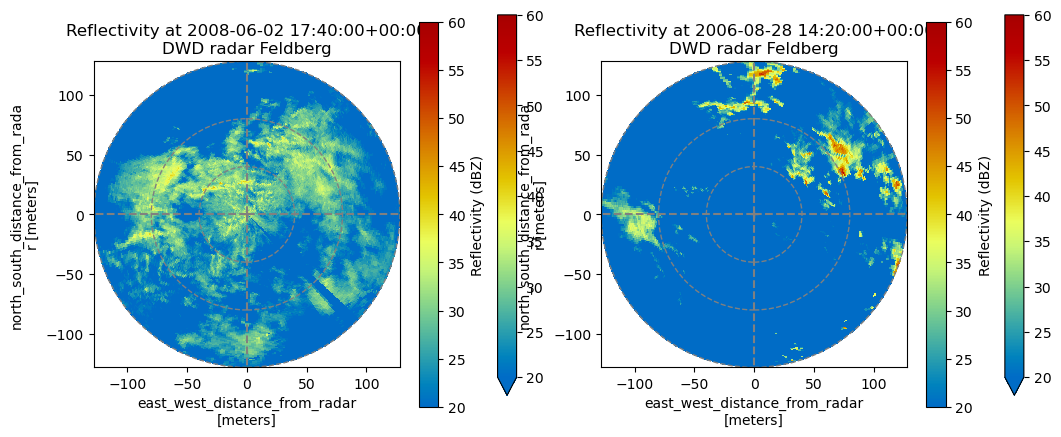

In [7]:
fig = plt.figure(figsize=(12, 10))
# Add first subplot (stratiform)
ax = plt.subplot(121, aspect="equal")
# Plot PPI,
da = wrl.georef.create_xarray_dataarray(one_scan).wrl.georef.georeference()
pm = da.wrl.vis.plot(ax=ax, vmin=20, vmax=60)
# add crosshair,
ax = wrl.vis.plot_ppi_crosshair((0, 0, 0), ranges=[40, 80, 128])
# add colorbar,
cbar = plt.colorbar(pm, shrink=0.5)
cbar.set_label("Reflectivity (dBZ)")
# add title,
plt.title("Reflectivity at {0}\nDWD radar Feldberg".format(metadata[0]["datetime"]))
# and zoom in.
plt.xlim((-128, 128))
plt.ylim((-128, 128))
# Add second subplot (convective)
ax = plt.subplot(122, aspect="equal")
# Plot PPI,
da = wrl.georef.create_xarray_dataarray(two_scans[0]).wrl.georef.georeference()
pm = da.wrl.vis.plot(ax=ax, vmin=20, vmax=60)
# add crosshair,
ax = wrl.vis.plot_ppi_crosshair((0, 0, 0), ranges=[40, 80, 128])
# add colorbar,
cbar = plt.colorbar(pm, shrink=0.5)
cbar.set_label("Reflectivity (dBZ)")
# add title,
plt.title("Reflectivity at {0}\nDWD radar Feldberg".format(attributes["datetime"]))
# and zoom in.
plt.xlim((-128, 128))
plt.ylim((-128, 128))

The radar data was kindly provided by the German Weather Service.